In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient
from class_tou import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from time-homogeneous OU process, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [4]:
alpha = torch.tensor([0.]).repeat(1, 1)
beta = torch.tensor([1.]).repeat(1, 1)
z0 = torch.tensor([10.]).repeat(1,1)
sde_sigma = 1.

In [5]:
true_sde = OU(t0 = 0, t1 = 8., z0 = z0, alpha = alpha, beta = beta, sigma = torch.tensor(sde_sigma).repeat(1,1), dN=801, timegrid='True')

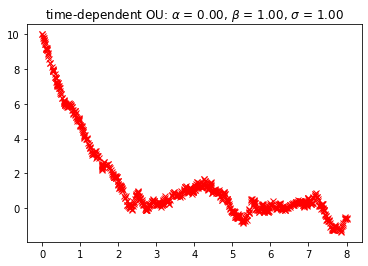

In [6]:
plt.plot(true_sde.pts.T, true_sde.trj.T, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [7]:
obs_sigma = 0.1
obs = torch.from_numpy(np.random.normal(loc = true_sde.trj[0][::100], scale = obs_sigma)).reshape(-1, 1)
obs_time = true_sde.pts[0][::100]

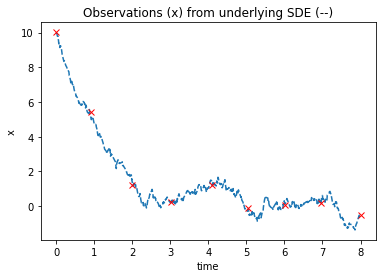

In [8]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Class: OU processes**

Variational inference: KL

$$\log\exp{\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}}^{t_{1}}-Z_{t} + r(Z_{t}-m(t))-m'(t)dZ_{t} - 
\frac{1}{2}\int_{t_{0}}^{t_{1}}Z^{2}_{t} - (-r(Z_{t}-m(t) + m'(t))^{2}dt$$

where the relevant functions

$$m(t) = \alpha (B(t, \beta) - 1) + m_{0}$$

$$m'(t) = \alpha \beta B(t, \beta - 1)$$

$$B(s, \beta) = (s + 1)^{\beta}$$

In [25]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = ou.sigma
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
#         func = lambda s, z: -0.5 * (1-(r**2)) * z * z + alpha * beta * ( r * B(s, beta-1) + 1) * z \
#                     -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
#                     -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
#                     * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta * B(s, beta - 1))

        def m(s):
            return alpha * (B(s, beta) - 1) + m0
            
        def m_(s):
            return alpha * beta * B(s, beta-1)
        
        func = lambda s, z: ( (1-r) * z + r * m(s) + m_(s) ) * ( (1+r) * z - r * m(s) - m_(s)) \
                      
        
        # re-arrange t so that it starts from 0
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        num = func(t, self.ou.trj)
        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = alpha.shape[0]
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        t0 = t[:, 0]
        t1 = t[:, -1]

        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
        
        def B(s, beta):
            return (s+1) ** beta
        
        integral = lambda s, z: r * alpha * beta * B(s, beta-1) * z + alpha * beta * z
        
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0) + torch.trapezoid(integral(t, self.ou.trj), x=t).reshape(-1, 1)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [26]:
import tqdm as tq

In [27]:
D = 50
S = 100
learning_rate = 0.0001
lr = learning_rate
IT = 200
dN = 200
z0 = obs[0]

# Linear mean function
beta_ = torch.tensor([1.])
beta_D = beta_.repeat(D, 1)
beta_S = beta_.repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

sde_sigma_D = torch.tensor([sde_sigma]).repeat(D, 1)
sde_sigma_S = torch.tensor([sde_sigma]).repeat(S, 1)
for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1)
    m0_ = torch.rand(1)
    
    i = 0
    for i in range(IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma_D, r=r_D, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)

        gradient = tou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, m0_D, r_D, sde_sigma_D]).view(-1, D, 1))
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * gradient['m0'])
        alpha_grad = torch.nanmean(f_of_X * gradient['alpha'])
        r_grad = torch.nanmean(f_of_X * gradient['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_.repeat(S,1), beta = beta_S, sigma = sde_sigma_S, r = r_.repeat(S,1), dN = dN, timegrid='True')

    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.04413825] m0 =  [0.5157464] r =  [0.5267029]
(Neg) elbo =  69.485026536938
alpha =  [-0.05886502] m0 =  [0.5103448] r =  [0.7117191]
(Neg) elbo =  25.3028126759221
alpha =  [-0.04101342] m0 =  [0.5190416] r =  [0.73852473]
(Neg) elbo =  26.931053212112786
alpha =  [-0.02266703] m0 =  [0.5291063] r =  [0.75220937]
(Neg) elbo =  31.58401359676487


 12%|█████▋                                       | 1/8 [00:07<00:55,  7.86s/it]

alpha =  [-0.02045967] m0 =  [0.2784008] r =  [0.4380466]
(Neg) elbo =  277.55125792153393
alpha =  [-0.30570534] m0 =  [0.1295547] r =  [1.1621469]
(Neg) elbo =  21.844204708192002
alpha =  [-0.2910181] m0 =  [0.13960834] r =  [1.2166213]
(Neg) elbo =  26.299925665783952
alpha =  [-0.26739207] m0 =  [0.1559854] r =  [1.2470529]
(Neg) elbo =  17.513634977517228


 25%|███████████▎                                 | 2/8 [00:15<00:46,  7.79s/it]

alpha =  [-0.00832844] m0 =  [0.18180363] r =  [0.41733655]
(Neg) elbo =  59.28638794984588
alpha =  [-0.21294625] m0 =  [0.0987127] r =  [0.6661051]
(Neg) elbo =  21.457886603752936
alpha =  [-0.29091972] m0 =  [0.05830262] r =  [0.81737554]
(Neg) elbo =  17.086051915359324
alpha =  [-0.28833935] m0 =  [0.05961394] r =  [0.907362]
(Neg) elbo =  24.654327176002695


 38%|████████████████▉                            | 3/8 [00:23<00:38,  7.79s/it]

alpha =  [0.00988562] m0 =  [0.4562522] r =  [0.00016914]
(Neg) elbo =  118.85857051173276
alpha =  [0.27158412] m0 =  [0.68139315] r =  [8.588291]
(Neg) elbo =  6.9729473752093964
alpha =  [0.3471493] m0 =  [0.74800426] r =  [8.588331]
(Neg) elbo =  4.946785231056269
alpha =  [0.37458244] m0 =  [0.76692635] r =  [8.58808]
(Neg) elbo =  6.265159057770799


 50%|██████████████████████▌                      | 4/8 [00:31<00:31,  7.76s/it]

alpha =  [-0.009184] m0 =  [0.36444762] r =  [0.8370144]
(Neg) elbo =  68.23443618598411
alpha =  [-0.30152825] m0 =  [0.18453676] r =  [1.0202305]
(Neg) elbo =  25.30977851761599
alpha =  [-0.4242984] m0 =  [0.10157458] r =  [1.139181]
(Neg) elbo =  17.767481170194802
alpha =  [-0.47772706] m0 =  [0.06332336] r =  [1.2123619]
(Neg) elbo =  18.147306657981513


 62%|████████████████████████████▏                | 5/8 [00:38<00:23,  7.78s/it]

alpha =  [-0.00046775] m0 =  [0.312686] r =  [0.38727212]
(Neg) elbo =  35.950643545812326
alpha =  [0.01374993] m0 =  [0.31831214] r =  [0.52892196]
(Neg) elbo =  17.387364042146462
alpha =  [0.015958] m0 =  [0.32004148] r =  [0.66550505]
(Neg) elbo =  15.718575757203796
alpha =  [0.01707305] m0 =  [0.3201953] r =  [0.76826334]
(Neg) elbo =  19.60828322286316


 75%|█████████████████████████████████▊           | 6/8 [00:46<00:15,  7.80s/it]

alpha =  [0.00177822] m0 =  [0.04701142] r =  [0.17380299]
(Neg) elbo =  32.458330878911646
alpha =  [0.0214341] m0 =  [0.05091717] r =  [0.30981696]
(Neg) elbo =  40.82710912470048
alpha =  [0.04027136] m0 =  [0.05635136] r =  [0.44123054]
(Neg) elbo =  36.70486101484577
alpha =  [0.06710389] m0 =  [0.06640239] r =  [0.5654711]
(Neg) elbo =  29.247259201180942


 88%|███████████████████████████████████████▍     | 7/8 [00:54<00:07,  7.79s/it]

alpha =  [-0.01210272] m0 =  [0.16159911] r =  [0.94035965]
(Neg) elbo =  51.511755019328106
alpha =  [-0.26553085] m0 =  [0.00643249] r =  [1.0275275]
(Neg) elbo =  30.01026626852167
alpha =  [-0.3523714] m0 =  [-0.04962031] r =  [1.107195]
(Neg) elbo =  16.532634432738526
alpha =  [-0.41375062] m0 =  [-0.09041537] r =  [1.1793813]
(Neg) elbo =  18.669211447300437


100%|█████████████████████████████████████████████| 8/8 [01:02<00:00,  7.79s/it]


Trace plot: ELBO

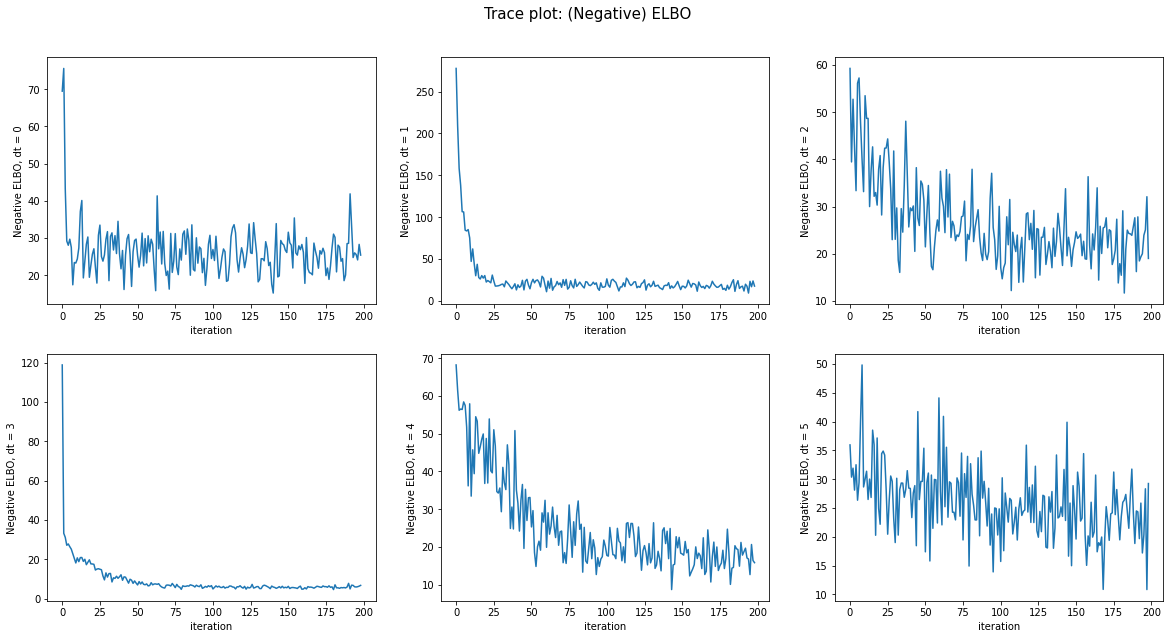

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

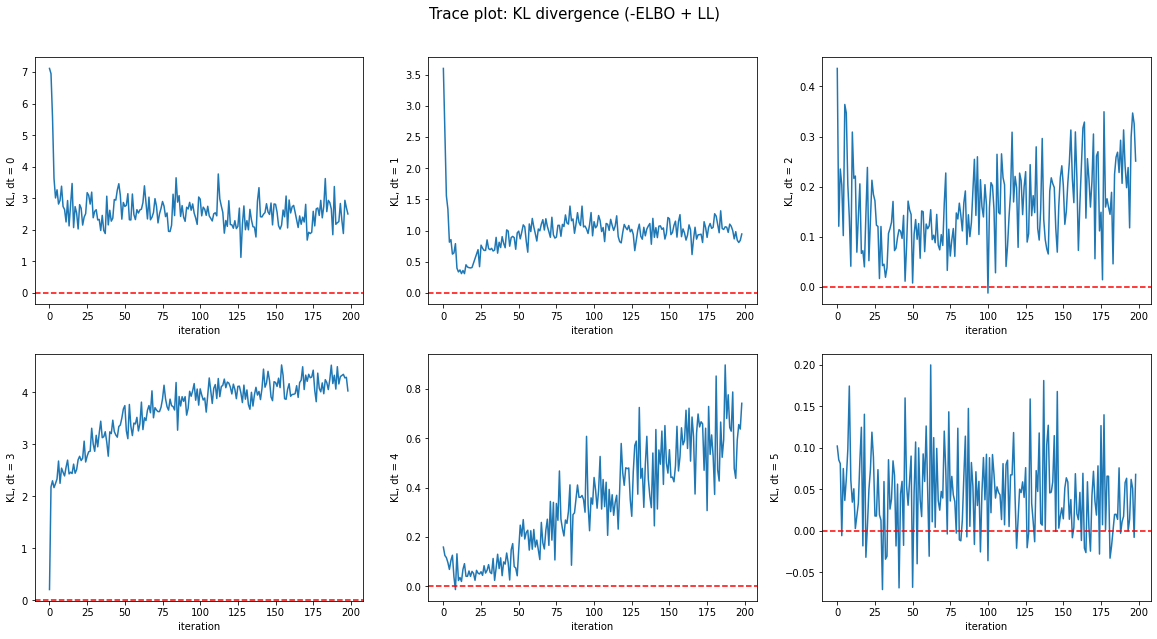

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence (-ELBO + LL)", size=15, y=0.95)
plt.show()

Trace plot: NLL

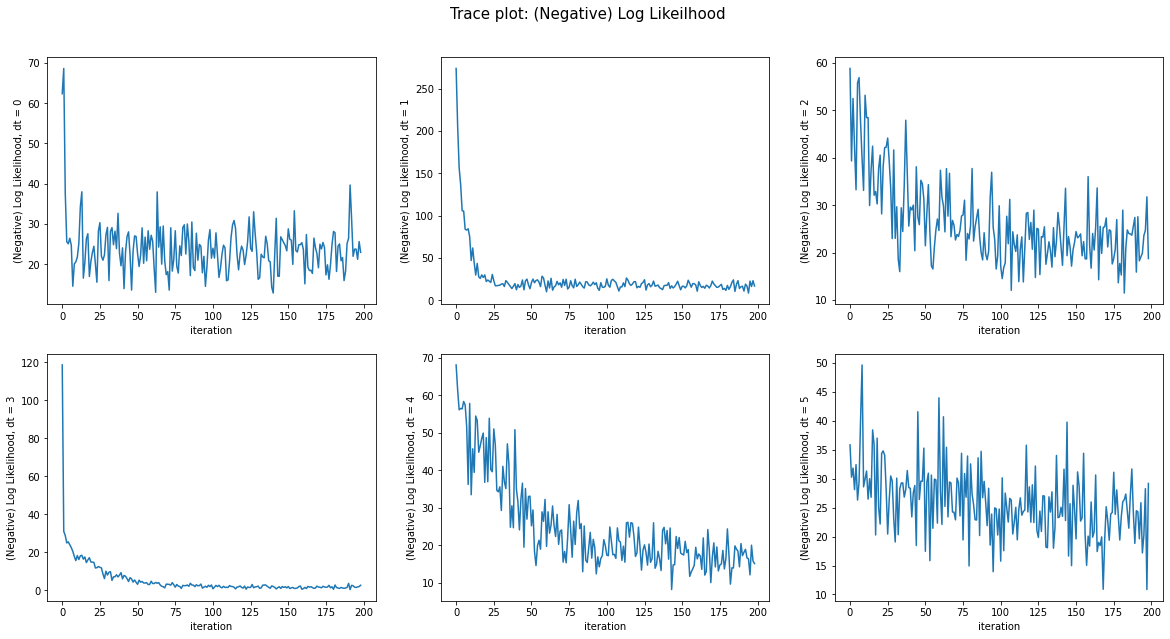

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

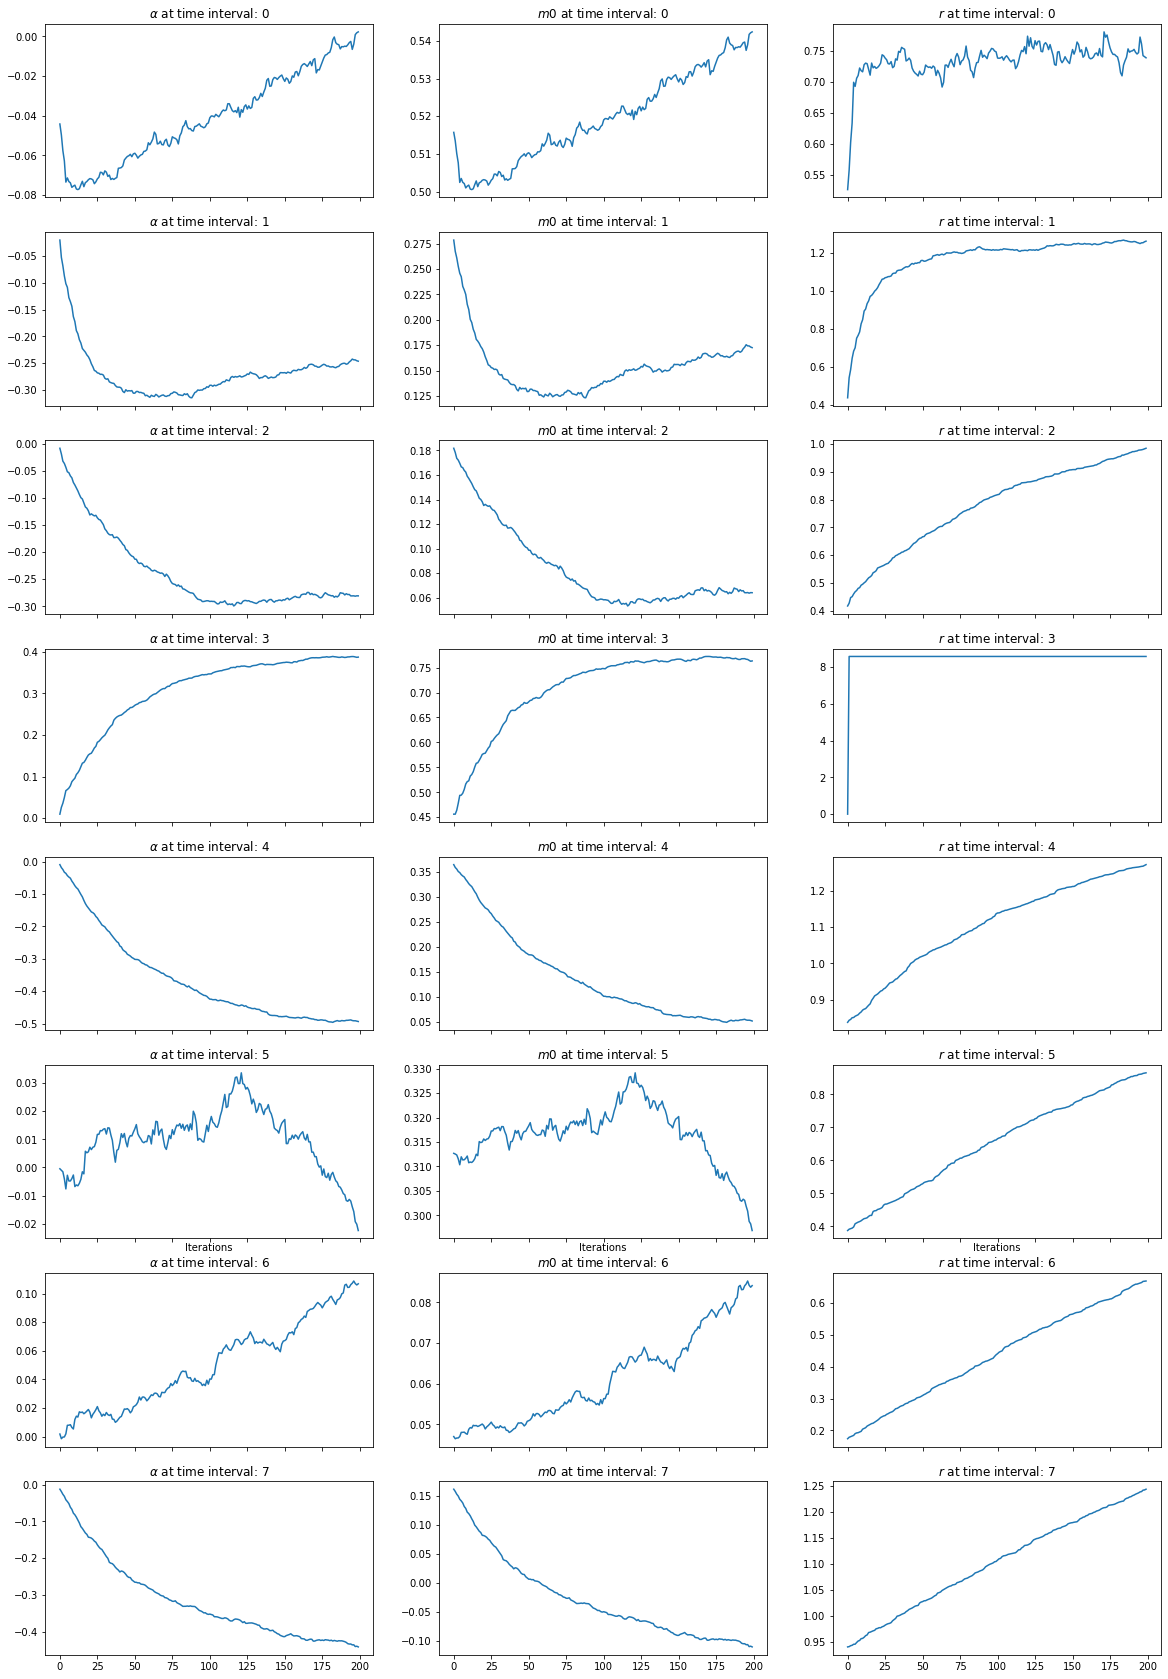

In [31]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

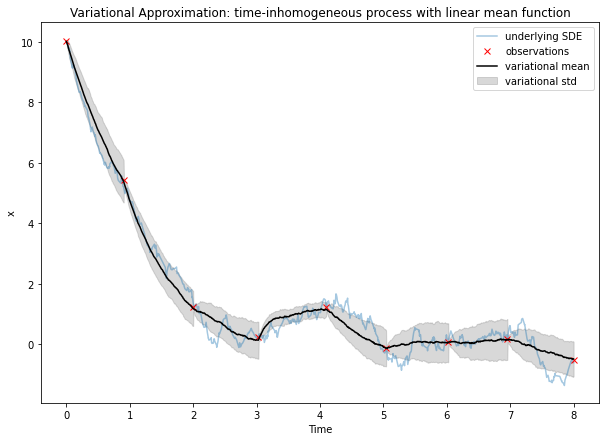

In [33]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-inhomogeneous process with linear mean function")
plt.show()

In [ ]:
import pickle

In [ ]:
with open('EX02_OU', 'wb') as f:
    pickle.dump(true_sde, f)
    pickle.dump(obs, f)
    pickle.dump(obs_time, f)
    pickle.dump(obs_sigma, f)
    pickle.dump(sde_sigma, f)